# 04. PyTorch Custom Datasets Video Notebook

We've used some datasets with PyTorch before.

But how do you get your own data into PyTorch?

One of the ways to do so is via: custom datasets.

## Domain libraries

Depending on what you're working on, vision, text, audio, recommendation, you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.

## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

torch.__version__
# Setup device-agnostic code
device = "mps" if torch.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
device

'mps'

## 1. Get some data

Our dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing).

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25testing).

Why do this?

When starting our ML projects, it's important to try things on a small scale and then increase the scale when necessary.

The whole point is to speed up how fast you can experiment.

In [2]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory already exists... skipping download.")
else:
    print(f"{image_path} does not exist, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)
    
# %echo "data/" >> .gitignore

data/pizza_steak_sushi directory already exists... skipping download.
Unzipping pizza, steak, sushi data...


## 2. Becoming one with the data (data preparation and data exploration)

In [3]:
import os
def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.
    Args:
        dir_path (str or pathlib.Path): target directory
    
    Returns:
        A print out of:
            number of subdirectories in dir_path
            number of images (files) in each subdirectory
            name of each subdirectory
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}.'")

In [4]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi.'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test.'
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak.'
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi.'
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza.'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train.'
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak.'
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi.'
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza.'


In [5]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing and image

Let's write some code to:
1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python's PIL
5. We'll then show the image and print metadata

Random image path: data/pizza_steak_sushi/test/pizza/2236338.jpg
Image class: pizza
Image height: 512
Image width: 512


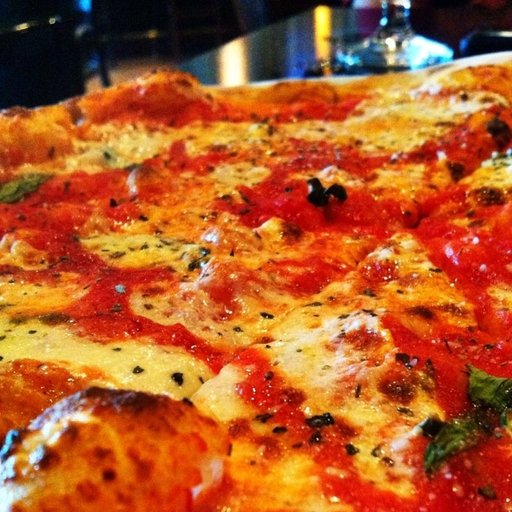

In [6]:
import random
from PIL import Image

# Set seed
random.seed(42)
# change this will affect selecting different images (or 'seed')

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2.  Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

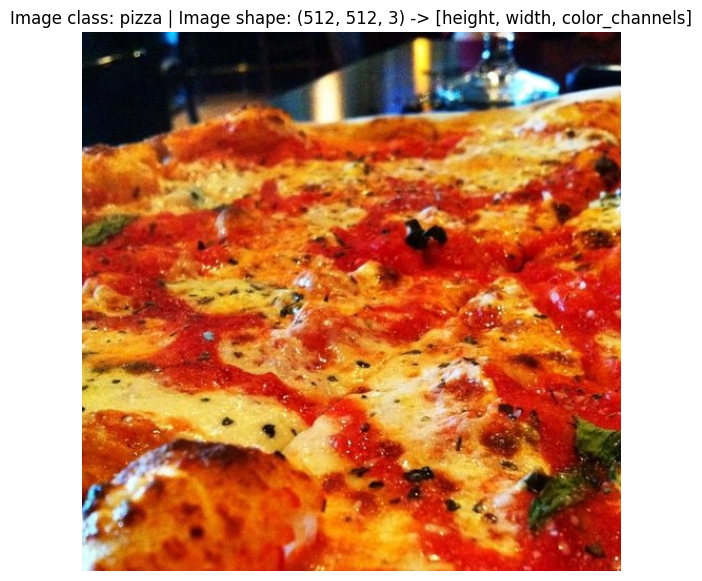

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)


## 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our cae, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`

In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to be used with a model/perform data augmentation

In [9]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor()   # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

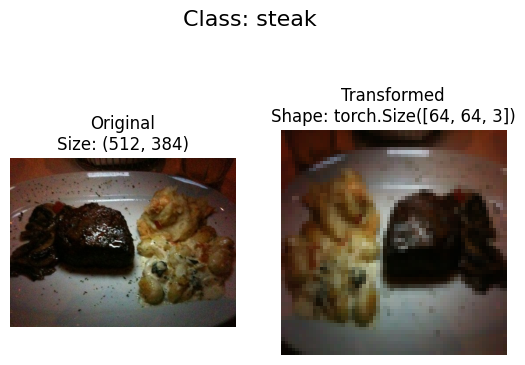

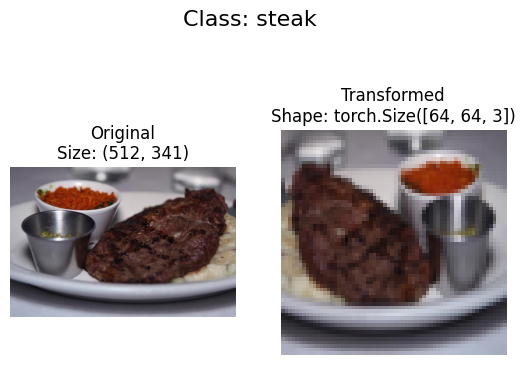

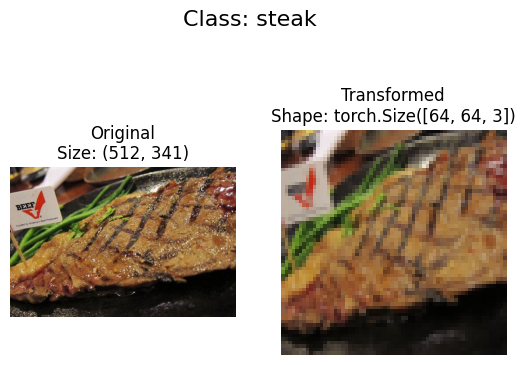

In [10]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
    """
    Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    will transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defautls to 42.
    """
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, transform=data_transform, n=3)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`

In [11]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,   # target folder of images
                                  transform=data_transform, # a transform for the data
                                  target_transform=None)    # a transform for the target/label

test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [12]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [13]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [14]:
# Check the lengths of our datasets
len(train_data), len(test_data)

(225, 75)

In [15]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Img datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")
print(f"class_names: {class_names[label]}")

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

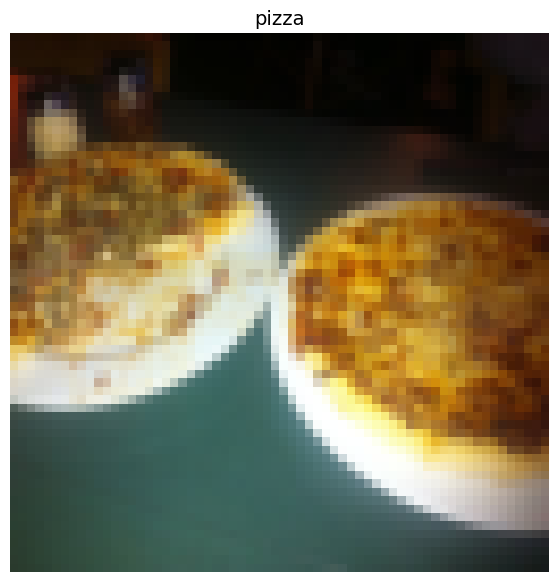

In [16]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis(False)
plt.title(class_names[label], fontsize=14)

In [17]:
# Turn train and test Datasets into Dataloaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1, # how many samples per batch
                              num_workers=1,    # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x13f2349e0>,
 <torch.utils.data.dataloader.DataLoader at 0x13f1cf500>)

In [18]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


### 4.1 Turn loaded images into `DataLoader`'s

A `DataLoader` is going to help us turn our `Dataset`'s into iterables and we can customise the `batch_size` so our model can see `batch_size` images at a time.

In [19]:
import os
os.cpu_count()

16

In [20]:
# Turn train and test datasets into Dataloader's
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x13f0d6e70>,
 <torch.utils.data.dataloader.DataLoader at 0x13f0d7cb0>)

In [21]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [22]:
len(train_data), len(test_data)

(225, 75)

In [23]:
img, label = next(iter(train_dataloader))

# Batch size will now be 32, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape} -> [batch_size]")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32]) -> [batch_size]


## 5 Option 2: Loading Image Data with a Custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it doesn't mean it will work...
* Using a custom `Dataset` often results in us writing more code, which could be prone to performance issues

In [24]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [25]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class name using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dict and a list and return them.

In [26]:
# Setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

Target directory: data/pizza_steak_sushi/train
Class names found: ['pizza', 'steak', 'sushi']


In [27]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """
    Finds the class folder names in a target directory

    Assumes target directory is in standard image classification format.

    Args:
        directory(str): target directory to load classnames from.
    
    Returns:
        Tuple[List[str], Dict[str, int]]:   (list_of_class_names, dict(class_name: idx...))
    
    Examples:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")
    
    # 3. Create a dictionary of index labels (computers prefer numebers rather than strings as labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

    return classes, class_to_idx

In [28]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
   * paths - paths of our images
   * transform - the transform we'd like to use
   * classes - a list of the target classes
   * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index

In [29]:
# 0. Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # 2. Initialize our custom dataset
    def __init__(self, targ_dir: str, transform=None) -> None:
        # 3. Create class attributes
        # Get all of the image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))   # note: you'd have to update this if you've got .png's or jpeg's
        # Setup transform
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Create a function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method to return a particular sample (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name = self.paths[index].parent.name  # expects path in format: data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx   # return data, label (X, y)
        else:
            return img, class_idx   # return untransformed data, label

In [30]:
img, label = train_data[0]
img, label

(tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
          [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
          [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
          ...,
          [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
          [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
          [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],
 
         [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
          [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
          [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
          ...,
          [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
          [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
          [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],
 
         [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
          [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
          [0.0196, 0.0157, 0.0157,  ...,

In [31]:
# Create a transform
from torchvision import transforms

# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [32]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir, transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir, transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x13f1e7260>,
 <__main__.ImageFolderCustom at 0x13f255c10>)

In [33]:
len(train_data), len(train_data_custom), len(test_data), len(test_data_custom)

(225, 225, 75, 75)

In [34]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [35]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [36]:
# Check for equality between original ImageFolder Dataset and custom ImageFolderCustomDataset
print((len(train_data_custom) == len(train_data)) and (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibilitiy.
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample images and plot them with matplotlib.
7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [37]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.dataset.Dataset, classes: List[str] = None, n: int = 10, display_shape: bool = True, seed: int = None):
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    # 3. Set random seed
    if seed:
        random.seed(seed)
    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)
    # 5. Setup plot
    plt.figure(figsize=(16, 8))
    # 6. Loop through random indexes and plot them with matplotlib
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [height, width, color_channels]
        targ_image_adjust = targ_image.permute(1, 2, 0)
        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis(False)
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title += f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

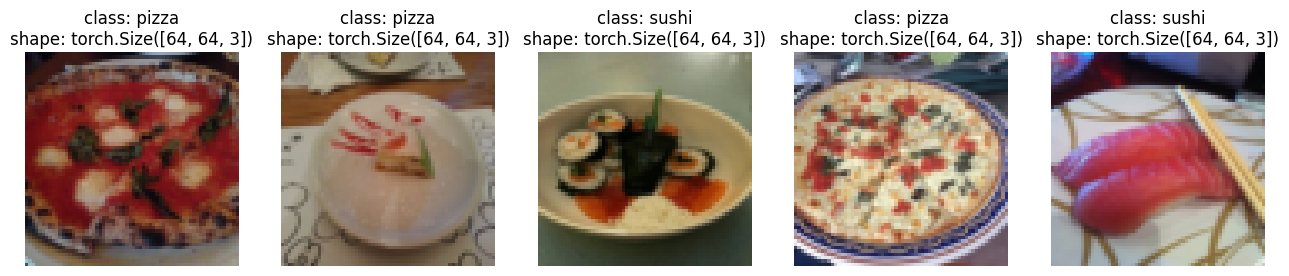

In [38]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data, n=5, classes=class_names, seed=None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


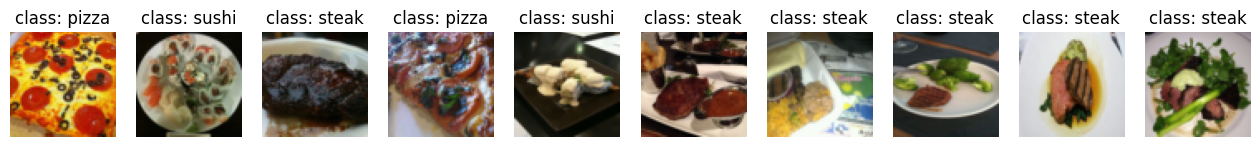

In [39]:
# Display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom, n=12, classes=class_names, seed=None)  # Try setting the seed for reproducibile images

### 5.4 Turn custom loaded images into DataLoader's

In [40]:
# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = 0
train_dataloader_custom = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=BATCH_SIZE,  # how many samples per batch?
                                     num_workers=NUM_WORKERS, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True)  # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False) # don't usually need to shuffle testing data

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x13f4989b0>,
 <torch.utils.data.dataloader.DataLoader at 0x13f0b0710>)

In [41]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


## 6. Other forms of trnasforms (data augmentation)

Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transformations to the training images.

This practice hopefully results in a model that's more generalizable to unseen data.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of teh art levels...

In [42]:
# Let's look at trivailaugment
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),   # how intense
    transforms.ToTensor()   # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
"""
Note: You usually don't perform data augmentation on the test set. The idea of data augmentation is to to artificially increase the diversity of the training set to better predict on the testing set.

However, you do need to make sure your test set images are transformed to tensors. We size the test images to the same size as our training images too, however, inference can be done on different size images if necessary (though this may alter performance).
"""

"\nNote: You usually don't perform data augmentation on the test set. The idea of data augmentation is to to artificially increase the diversity of the training set to better predict on the testing set.\n\nHowever, you do need to make sure your test set images are transformed to tensors. We size the test images to the same size as our training images too, however, inference can be done on different size images if necessary (though this may alter performance).\n"

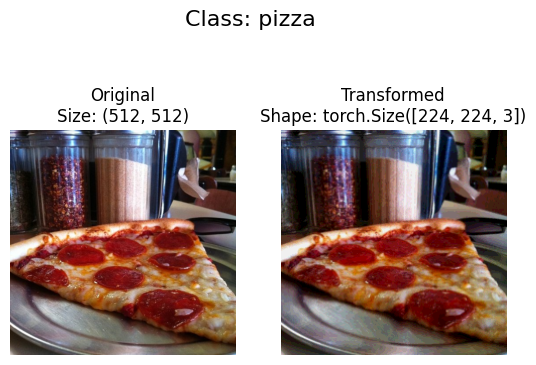

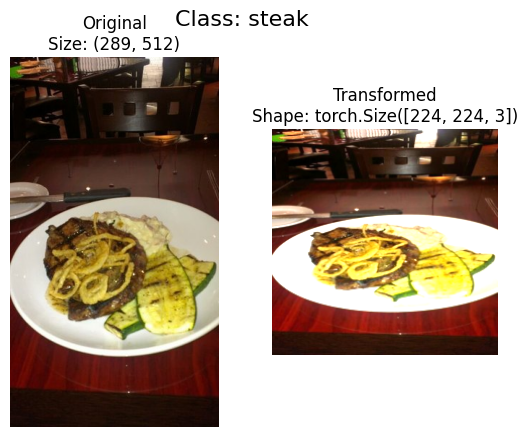

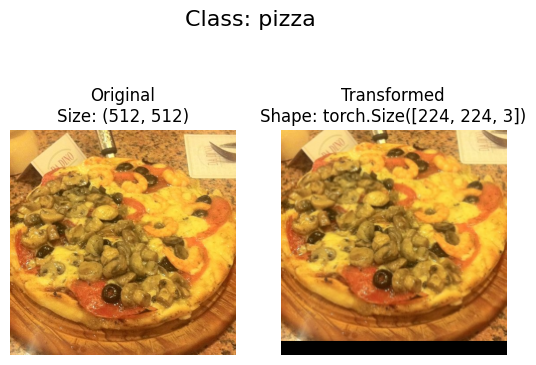

In [43]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transforms,
                        n=3,
                        seed=None)

## 7. Model 0: TinyVGG without data augmentation

Let's replicate TinyVGG architecture from the CNN Explainer website: https://poloclub.github.io/cnn-explainer/

### 7.1 Creating transforms and loading data for Model 0

In [44]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [45]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Turn datasets into DataLoader
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers...")

# Create DataLoader's
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)
train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 16 workers...


(<torch.utils.data.dataloader.DataLoader at 0x13f60cfe0>,
 <torch.utils.data.dataloader.DataLoader at 0x13f61ee10>)

### 7.2 Create TinyVGG model class

In [46]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, 
                      kernel_size=3,    # how big is the square that's going over the image?
                      padding=1,    # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
                      stride=1),    # default
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, 
                         stride=2)  # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16, out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x)))   # benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,    # number of color channels in our image data
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

In [47]:
# Get a single image batch
img_batch, label_batch = next(iter(train_dataloader_simple))

In [48]:
# Try a forward pass
model_0(img_batch.to(device))

tensor([[0.0578, 0.0634, 0.0351],
        [0.0657, 0.0650, 0.0398],
        [0.0702, 0.0678, 0.0412],
        [0.0687, 0.0646, 0.0417],
        [0.0625, 0.0613, 0.0355],
        [0.0587, 0.0595, 0.0358],
        [0.0634, 0.0637, 0.0376],
        [0.0653, 0.0615, 0.0376],
        [0.0678, 0.0621, 0.0349],
        [0.0620, 0.0599, 0.0371],
        [0.0607, 0.0628, 0.0387],
        [0.0638, 0.0589, 0.0352],
        [0.0658, 0.0611, 0.0369],
        [0.0703, 0.0689, 0.0330],
        [0.0557, 0.0571, 0.0356],
        [0.0632, 0.0642, 0.0388],
        [0.0639, 0.0616, 0.0375],
        [0.0605, 0.0600, 0.0374],
        [0.0623, 0.0627, 0.0368],
        [0.0740, 0.0676, 0.0400],
        [0.0621, 0.0613, 0.0361],
        [0.0632, 0.0599, 0.0366],
        [0.0662, 0.0627, 0.0334],
        [0.0637, 0.0622, 0.0394],
        [0.0670, 0.0666, 0.0363],
        [0.0650, 0.0601, 0.0405],
        [0.0639, 0.0597, 0.0395],
        [0.0733, 0.0687, 0.0412],
        [0.0697, 0.0631, 0.0402],
        [0.062

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [49]:
from torchinfo import summary

summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

## 7.5 Create train and test loops functions

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader.
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader.

In [50]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
    # Put the model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through the dataloader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to the target device
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass
        y_pred = model(X)
        
        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        
        # 4. Loss backward
        loss.backward()
        
        # 5. Optimizer step
        optimizer.step()
        
        # Calculate accuracy metrics
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += torch.sum(y_pred_class == y).item() / len(y_pred)
        
    # Adjust metrics to get average loss and accuracy per batch
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc
        
        

In [51]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
    # Put the model in eval mode
    model.eval()
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference mode
    with torch.inference_mode():
        # Loop through Dataloader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred_logits = model(X)
            
            # 2. Calculate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += torch.sum(test_pred_labels == y).item() / len(test_pred_labels)
    
    # Adjust metrics to get average loss and accuracy per batch
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [52]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloaders
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int=5,
          device=device):
    # 2. Create empty results dictionary
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        
        # 4. Print out what's happening
        print(f"Epoch: {epoch+1} | "
              f"Train loss: {train_loss:.4f} | "
              f"Train accuracy: {train_acc:.2f} | "
              f"Test loss: {test_loss:.4f} | "
              f"Test accuracy: {test_acc:.2f}")
        
        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
    # 6. Return the filled results at the end of epochs
    return results

### 7.7 Train and evaluate model 0

In [53]:
# Set random seeds
torch.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,    # number of color channels of our target images
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to("mps")

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001) # learning rate

# Start the timer()
from timeit import default_timer as timer
start_time = timer()

# Train the model_0
model_0_results = train(model=model_0,
                         train_dataloader=train_dataloader_simple,
                         test_dataloader=test_dataloader_simple,
                         optimizer=optimizer,
                         loss_fn=loss_fn,
                         epochs=NUM_EPOCHS,
                         device="mps")

# End the timer and print out how long it took
end_time = timer()
print(f"Training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 1.1078 | Train accuracy: 0.26 | Test loss: 1.1362 | Test accuracy: 0.26
Epoch: 2 | Train loss: 1.0846 | Train accuracy: 0.43 | Test loss: 1.1622 | Test accuracy: 0.20
Epoch: 3 | Train loss: 1.1155 | Train accuracy: 0.29 | Test loss: 1.1695 | Test accuracy: 0.20
Epoch: 4 | Train loss: 1.0983 | Train accuracy: 0.41 | Test loss: 1.1348 | Test accuracy: 0.20
Epoch: 5 | Train loss: 1.0989 | Train accuracy: 0.29 | Test loss: 1.1431 | Test accuracy: 0.20
Training time: 291.645 seconds


### 7.8 Plot the loss curves of Model 0

A **loss curve** is a way of tracking your model's progress over time

In [54]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [55]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """
    Plots training curves of a results dictionary.
    """
    # Get the loss values of the results dictionary(training and testing)
    train_loss = results["train_loss"]
    test_loss = results["test_loss"]
    
    # Get the accuracy values of the results dictionary(training and testing)
    train_acc = results["train_acc"]
    test_acc = results["test_acc"]
    
    # Figure out how many epochs there were
    epochs = range(len(train_loss))
    
    # Setup a plot
    plt.figure(figsize=(16, 7))
    
    # Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Train loss")
    plt.plot(epochs, test_loss, label="Test loss")
    plt.title("Loss curves")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="Train accuracy")
    plt.plot(epochs, test_acc, label="Test accuracy")
    plt.title("Accuracy curves")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

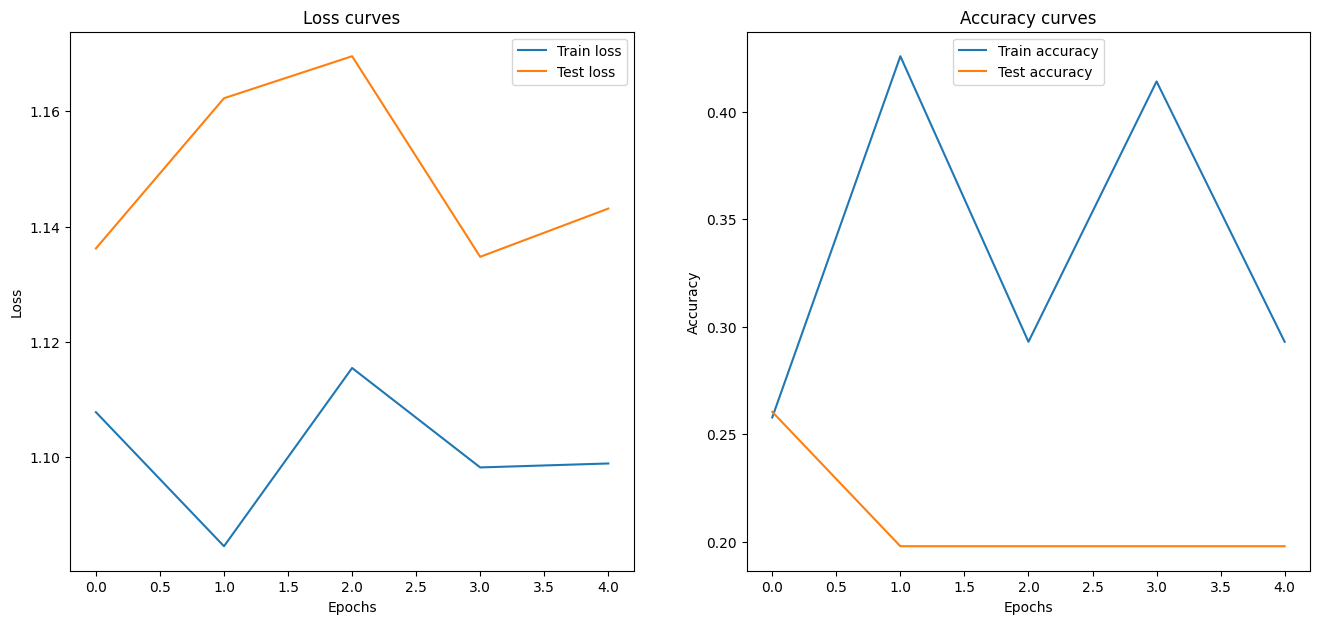

In [56]:
plot_loss_curves(model_0_results)

## 8. What should an ideal loss curve look like?

A loss curve is one of the most helpful ways to troubleshoot a model.

## 9. Model: TinyVgg with Data Augmentation

Now let's try another modelling experiment this time using the same model as before with some data augmentation.

### 9.1 Create transform with data augmentation

In [57]:
# Create training transform with TriviailAugment
from torchvision import transforms
train_transform_trivial = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_trainsform_simple = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

### 9.2 Create train and test `Dataset`'s and `DataLoader`'s with data augmentation

In [58]:
# Turn image folders into Datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                             transform=train_transform_trivial)
test_data_augmented = datasets.ImageFolder(root=test_dir,
                                            transform=test_trainsform_simple)


In [59]:
# Turn our Datasets into DataLoaders
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                         batch_size=BATCH_SIZE,
                                         num_workers=NUM_WORKERS,
                                         shuffle=True)
test_dataloader_augmented = DataLoader(dataset=test_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        num_workers=NUM_WORKERS,
                                        shuffle=False)


### 9.3 Construct and train model 1

This time we'll use the same model architecture except this time we've augmented the training data.

In [60]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=225, bias=True)
  )
)

Wonderful! Now we've a model and dataloaders, let's create a loss function and an optimizer and call upon our `train()` function to train and evaluate our model.

In [61]:
# Set random seeds
torch.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001) # learning rate

# Start the timer()
from timeit import default_timer as timer
start_time = timer()

# Train the model_1
model_1_results = train(model=model_1,
                         train_dataloader=train_dataloader_augmented,
                         test_dataloader=test_dataloader_simple,
                         optimizer=optimizer,
                         loss_fn=loss_fn,
                         epochs=NUM_EPOCHS,
                         device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time for model_1: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 4.3684 | Train accuracy: 0.38 | Test loss: 2.4038 | Test accuracy: 0.26
Epoch: 2 | Train loss: 1.4324 | Train accuracy: 0.43 | Test loss: 1.2714 | Test accuracy: 0.26
Epoch: 3 | Train loss: 1.2749 | Train accuracy: 0.27 | Test loss: 1.0574 | Test accuracy: 0.41
Epoch: 4 | Train loss: 1.1153 | Train accuracy: 0.33 | Test loss: 1.1642 | Test accuracy: 0.30
Epoch: 5 | Train loss: 1.1618 | Train accuracy: 0.33 | Test loss: 1.0135 | Test accuracy: 0.59
Total training time for model_1: 291.780 seconds


### 9.4 Plot the loss curves of model 1

A loss curve helps you evaluate your models performance overtime.

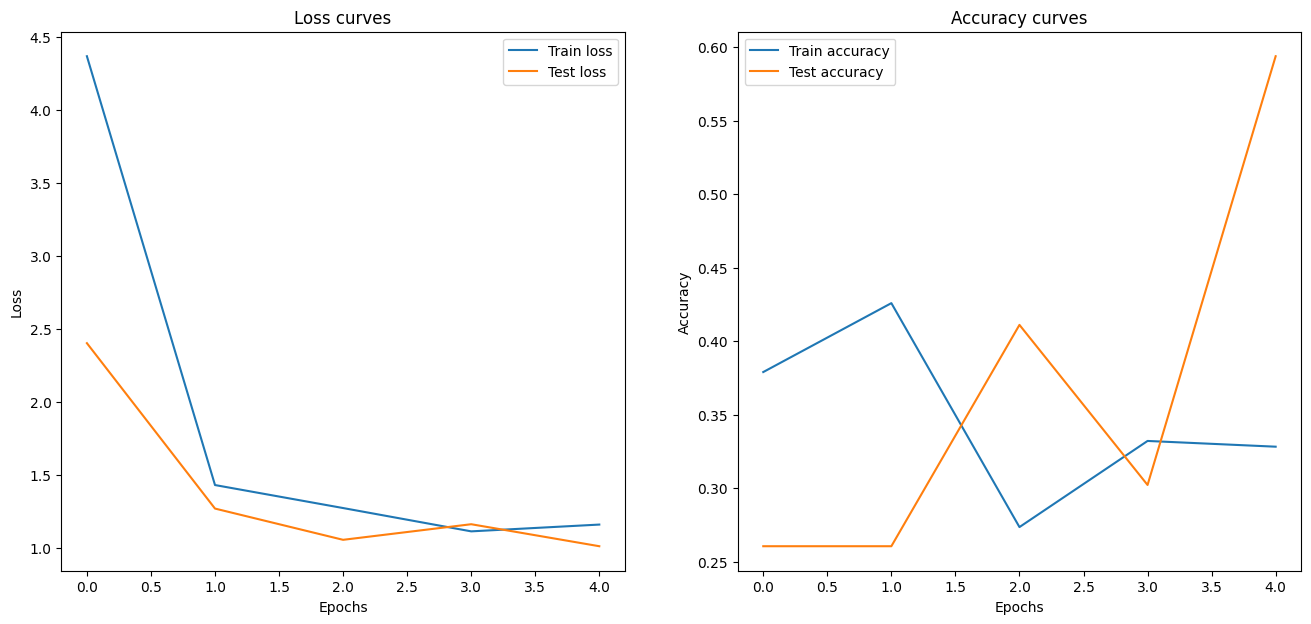

In [62]:
plot_loss_curves(model_1_results)

## 10. Compare model results

After evaluating our modelling experiments on their own, it's important to compare them to each other.

There's a few different ways to do this:
1. Hard coding (what we're doing)
2. PyTorch + Tensorboard
3. Weights & Biases
4. MLFlow

In [63]:
import pandas as pd

model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df, model_1_df

(   train_loss  train_acc  test_loss  test_acc
 0    1.107837   0.257812   1.136211  0.260417
 1    1.084599   0.425781   1.162248  0.197917
 2    1.115493   0.292969   1.169530  0.197917
 3    1.098255   0.414062   1.134762  0.197917
 4    1.098941   0.292969   1.143120  0.197917,
    train_loss  train_acc  test_loss  test_acc
 0    4.368432   0.378906   2.403837  0.260417
 1    1.432401   0.425781   1.271359  0.260417
 2    1.274930   0.273438   1.057387  0.410985
 3    1.115326   0.332031   1.164187  0.302083
 4    1.161775   0.328125   1.013549  0.593750)

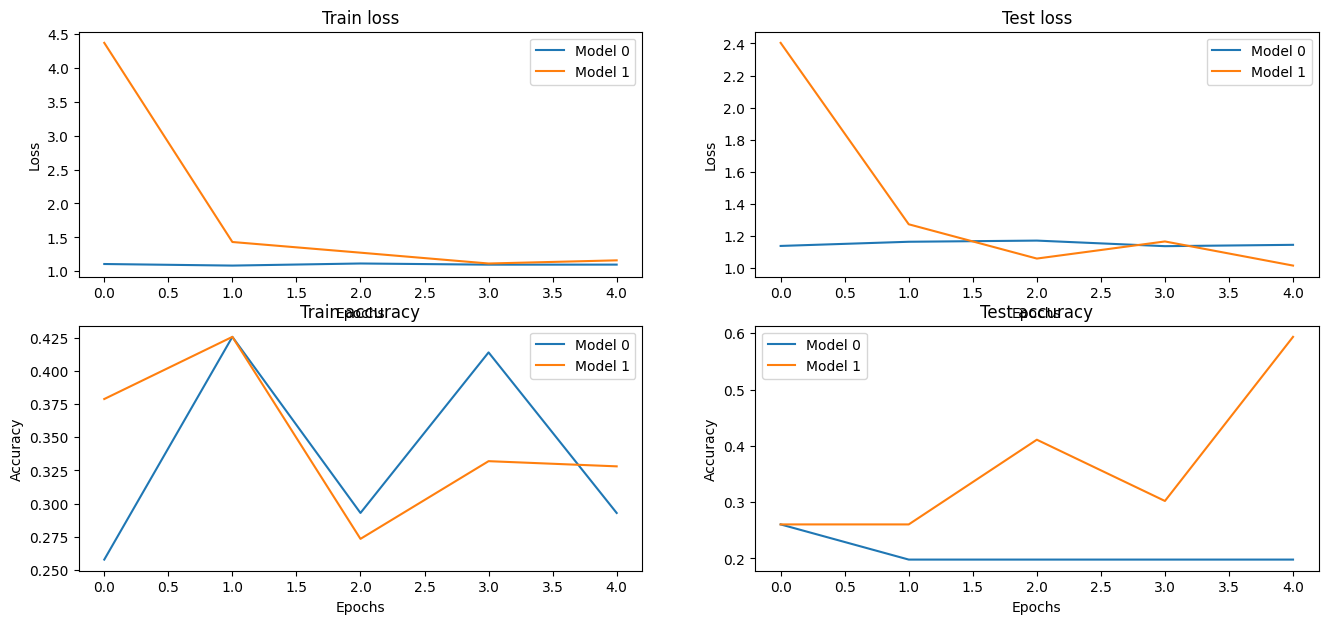

In [64]:
# Setup a plot
plt.figure(figsize=(16, 7))

# Get a number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

## 11. Making a prediction on a custom image

Although we've trained a model on custom data... how do you make a prediction on a sample/image that's not in either training or testing dataset.

In [65]:
# Download custom iamge
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to get the 'raw' file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists... skipping download...")

data/04-pizza-dad.jpeg already exists... skipping download...


### 11.1 Loading in a custom image with PyTorch

We have to make sure our custom image is in the same format as the data our model was trained on.

* In tensor form with datatype (torch.float32)
* Of shape 64x64x3
* On the right device

In [66]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
print(f"Custom image:\n {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape} -> [color_channels, height, width]")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image:
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024]) -> [color_channels, heig

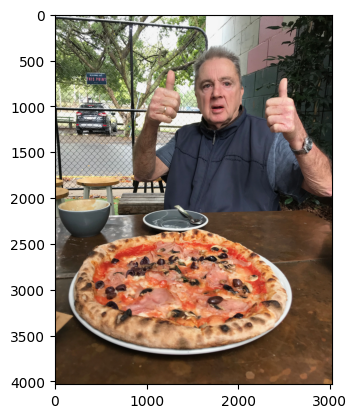

In [67]:
plt.imshow(custom_image_uint8.permute(1, 2, 0))

### 11.2 Making a prediction on a custom image with a trained PyTorch model

In [68]:
# Load in the custom image and convert to torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

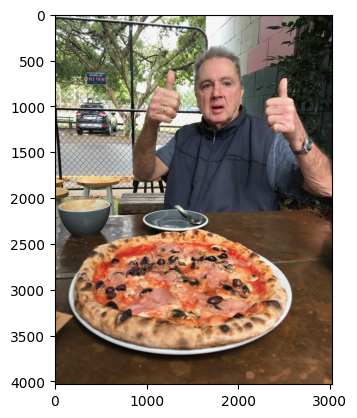

In [69]:
plt.imshow(custom_image.permute(1, 2, 0))

In [70]:
# Create transform pipeline to resize image
from torchvision import transforms
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64))
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out the shapes
print(f"Original image shape: {custom_image.shape} -> [color_channels, height, width]")
print(f"Transformed shape: {custom_image_transformed.shape} -> [color_channels, height, width]")

Original image shape: torch.Size([3, 4032, 3024]) -> [color_channels, height, width]
Transformed shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]


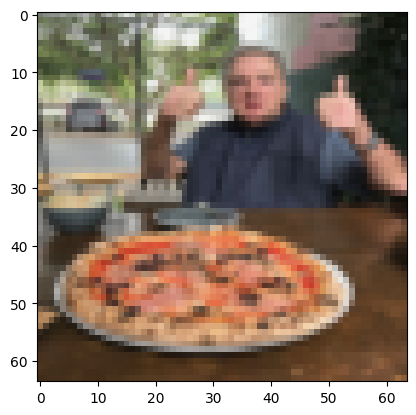

In [71]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))

In [72]:
custom_image_transformed.shape, custom_image_transformed.unsqueeze(0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [73]:
model_1.eval()
with torch.inference_mode():
    # Make a prediction on the transformed image
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

custom_image_pred

tensor([[ 10.5626,  10.4185,  10.5416, -14.5548, -14.4743, -14.1429, -14.8520,
         -13.9525, -14.3280, -14.0907, -14.4499, -14.5838, -14.3915, -14.5316,
         -14.0699, -14.2122, -14.2771, -14.3164, -14.3058, -13.9778, -14.5043,
         -14.6020, -14.2063, -14.2625, -14.1472, -13.9647, -14.3796, -14.1278,
         -14.3428, -14.4897, -14.4540, -14.0347, -14.3008, -14.7089, -14.3275,
         -14.3961, -14.4133, -14.6231, -14.3119, -14.3416, -14.4228, -14.6201,
         -14.3673, -14.0583, -14.5150, -14.3582, -14.0315, -14.1435, -14.0201,
         -14.3003, -14.4484, -14.4814, -14.5977, -14.1680, -14.4241, -14.5273,
         -14.3762, -14.1125, -14.1708, -14.3360, -14.6236, -14.3759, -14.4425,
         -14.6419, -14.2521, -14.1001, -14.4383, -14.2092, -14.2760, -14.1703,
         -14.2972, -14.6614, -14.5553, -14.1825, -14.0531, -14.3844, -14.0828,
         -14.6300, -14.3622, -14.6414, -14.3797, -14.4247, -14.3665, -14.1658,
         -14.5738, -14.4368, -14.4000, -14.4480, -14

Note, to make a prediction on a custom image we had to:
* Load the image and turn it into a tensor
* Make sure the image was the same datatype as the model (torch.float32)
* Make sure the image was the same shape as the data the model was trained on (3, 64, 64) with a batch size... (1, 3, 64, 64)
* Make sure the image was on the same device as our model

In [74]:
# Convert logits -> prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[3.5149e-01, 3.0433e-01, 3.4417e-01, 4.3406e-12, 4.7048e-12, 6.5532e-12,
         3.2246e-12, 7.9278e-12, 5.4460e-12, 6.9042e-12, 4.8209e-12, 4.2166e-12,
         5.1105e-12, 4.4426e-12, 7.0491e-12, 6.1145e-12, 5.7301e-12, 5.5094e-12,
         5.5679e-12, 7.7292e-12, 4.5655e-12, 4.1405e-12, 6.1508e-12, 5.8142e-12,
         6.5251e-12, 7.8313e-12, 5.1717e-12, 6.6528e-12, 5.3655e-12, 4.6329e-12,
         4.8009e-12, 7.3022e-12, 5.5961e-12, 3.7207e-12, 5.4484e-12, 5.0871e-12,
         5.0006e-12, 4.0543e-12, 5.5343e-12, 5.3724e-12, 4.9530e-12, 4.0663e-12,
         5.2358e-12, 7.1319e-12, 4.5170e-12, 5.2839e-12, 7.3254e-12, 6.5494e-12,
         7.4097e-12, 5.5987e-12, 4.8280e-12, 4.6715e-12, 4.1584e-12, 6.3908e-12,
         4.9470e-12, 4.4616e-12, 5.1897e-12, 6.7553e-12, 6.3728e-12, 5.4022e-12,
         4.0520e-12, 5.1910e-12, 4.8569e-12, 3.9786e-12, 5.8754e-12, 6.8400e-12,
         4.8773e-12, 6.1325e-12, 5.7363e-12, 6.3760e-12, 5.6163e-12, 3.9019e-12,
         4.3384e-12, 6.2986e

In [75]:
# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1).cpu()
custom_image_pred_label

tensor([0])

In [76]:
class_names[custom_image_pred_label]

'pizza'

### 11.3 Putting custom image prediction together: building a function

Ideal outcome:

A function where we pass an image path to and have our model predict on that image and plot the image + prediction.

In [ ]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform: transforms.Compose = None,
                        device=device):
    """
    Makes a prediction on a target image with a trained model and plots the image and prediction.
    """
    # Load in the image
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    
    # Divide the image pixel values by 255.0 to get them between 0 and 1
    target_image = target_image / 255.
    
    # Transform if necessary
    if transform:
        target_image = transform(target_image)
        
    # Make sure the model is on the target device
    model.to(device)
    
    # Turn on eval/inference mode and make a prediction
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image (this is the batch dimension, e.g. our model will predict on batches of 1x images)
        target_image = target_image.unsqueeze(0)
        
        # Make a prediction on the image with an extra dimension
        target_image_pred = model(target_image.to(device))  # make sure the model is on the target device
        
    # Convert logits -> prediction probabilities
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1).cpu()
    # Plot the image alongside the prediction and prediction probabilities
    plt.figure(figsize=(10, 7))
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # remove batch dimension and rearrange shape to be HWC
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label.cpu()} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    
    plt.title(title)
    plt.axis(False)

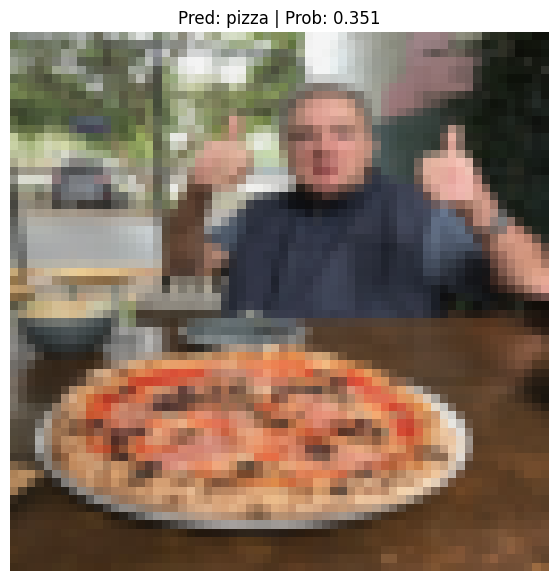

In [84]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)